In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fetal-health-classification/fetal_health.csv


In [2]:
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings(action='ignore')
data1=pd.read_csv("/kaggle/input/fetal-health-classification/fetal_health.csv")

DATA PREPROCESSING

In [3]:
data1.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [4]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [5]:
## Get cols with categorical types
def get_categ():
    categ_cols=[]
    for i in data1.columns:
        if(len(pd.unique(data1[i]))<=10 and (i!='severe_decelerations' and i!='fetal_health' and i!='prolongued_decelerations')):
            categ_cols.append(i)
    return categ_cols

In [6]:
categ_cols=get_categ()
categ_cols

['histogram_number_of_zeroes', 'histogram_tendency']

In [7]:
data2=data1.copy()

In [8]:
for i in categ_cols:
    data2=pd.concat([data2,pd.get_dummies(data2[i],prefix=i)],axis=1)
    data2.drop(i,axis=1,inplace=True)

In [9]:
data_outlier=data2.copy()
data_outlier.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_mode,histogram_mean,histogram_median,histogram_variance,fetal_health,histogram_number_of_zeroes_0.0,histogram_number_of_zeroes_1.0,histogram_number_of_zeroes_2.0,histogram_number_of_zeroes_3.0,histogram_number_of_zeroes_4.0,histogram_number_of_zeroes_5.0,histogram_number_of_zeroes_7.0,histogram_number_of_zeroes_8.0,histogram_number_of_zeroes_10.0,histogram_tendency_-1.0,histogram_tendency_0.0,histogram_tendency_1.0
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,120.0,137.0,121.0,73.0,2.0,1,0,0,0,0,0,0,0,0,0,0,1
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,141.0,136.0,140.0,12.0,1.0,0,1,0,0,0,0,0,0,0,0,1,0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,141.0,135.0,138.0,13.0,1.0,0,1,0,0,0,0,0,0,0,0,1,0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,137.0,134.0,137.0,13.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,137.0,136.0,138.0,11.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1


In [10]:
data_outlier.drop_duplicates(inplace=True)

In [11]:
for i in data_outlier:
    q1=data_outlier[i].quantile(.25)
    q3=data_outlier[i].quantile(.75)
    iqr=np.abs(q3-q1)
    lower_bound=q1-1.5*iqr
    upper_bound=q3+1.5*iqr
    if(i!='fetal_health'):
        data_outlier[i]=np.where(data_outlier[i]<lower_bound,lower_bound,np.where(data_outlier[i]>upper_bound,upper_bound,data_outlier[i]))

In [12]:
data_outlier['fetal_health']

0       2.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2121    2.0
2122    2.0
2123    2.0
2124    2.0
2125    1.0
Name: fetal_health, Length: 2113, dtype: float64

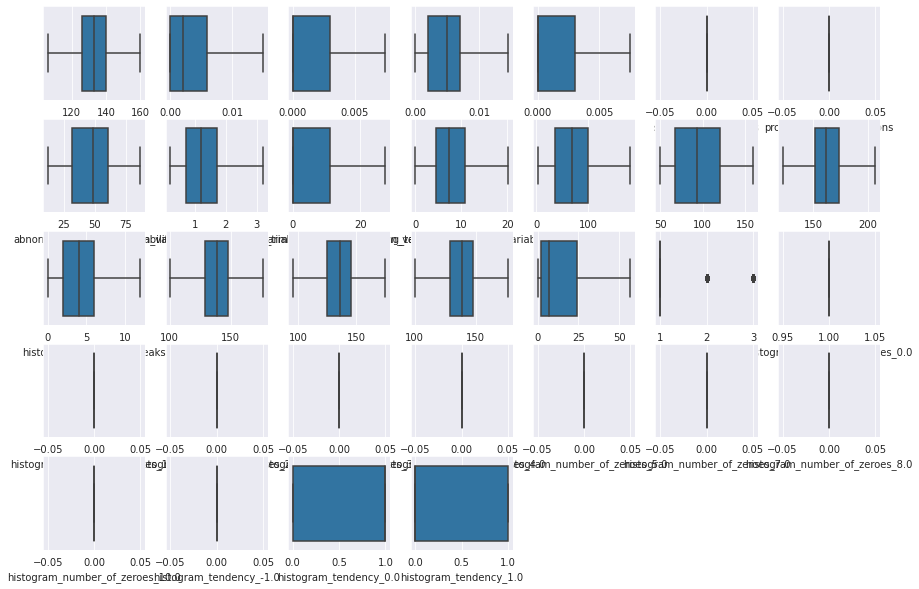

In [13]:
plt.figure(figsize=(15,10))
for i,j in enumerate(data_outlier):
    plt.subplot(5,7,i+1)
    sns.boxplot(data_outlier[j])

<AxesSubplot:>

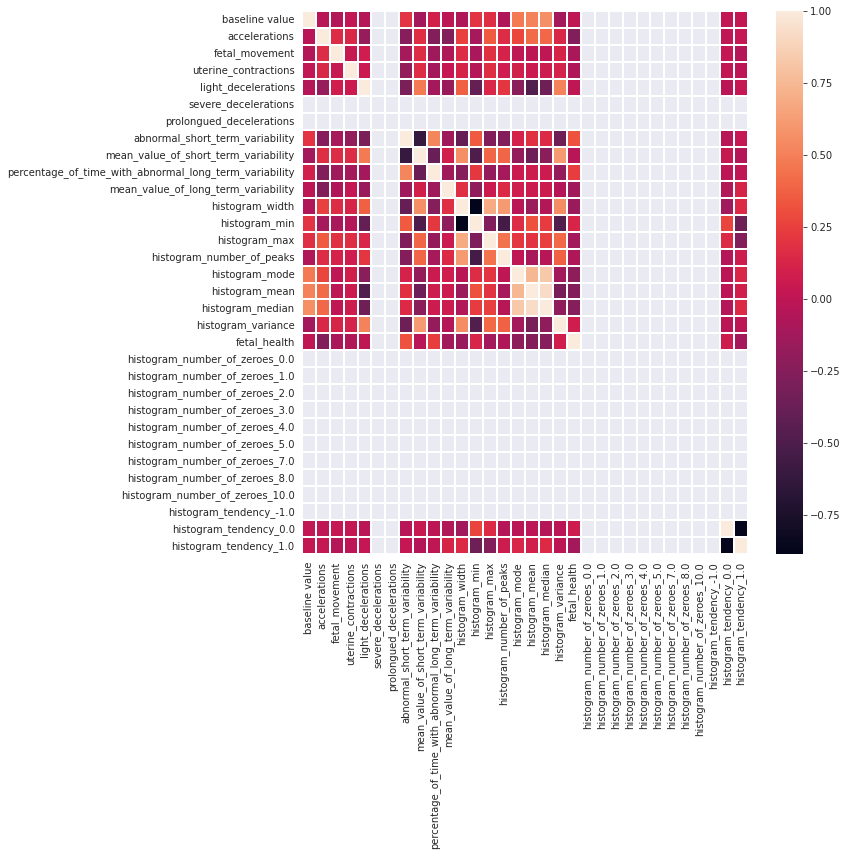

In [14]:
plt.figure(figsize=(10,10))
corr = data_outlier.diff().corr()
sns.heatmap(corr, linewidths=0.1, vmax=1.0, square=False, linecolor='white')

In [15]:
data_outlier.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_mode,histogram_mean,histogram_median,histogram_variance,fetal_health,histogram_number_of_zeroes_0.0,histogram_number_of_zeroes_1.0,histogram_number_of_zeroes_2.0,histogram_number_of_zeroes_3.0,histogram_number_of_zeroes_4.0,histogram_number_of_zeroes_5.0,histogram_number_of_zeroes_7.0,histogram_number_of_zeroes_8.0,histogram_number_of_zeroes_10.0,histogram_tendency_-1.0,histogram_tendency_0.0,histogram_tendency_1.0
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,27.5,2.4,64.0,62.0,126.0,2.0,120.0,137.0,121.0,57.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,141.0,136.0,140.0,12.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,141.0,135.0,138.0,13.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,20.1,117.0,53.0,170.0,11.0,137.0,134.0,137.0,13.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,137.0,136.0,138.0,11.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


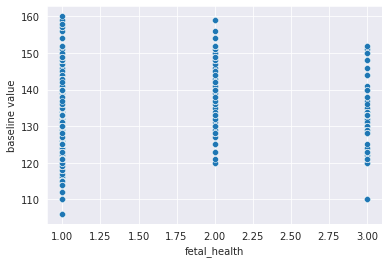

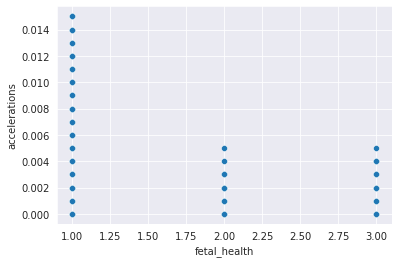

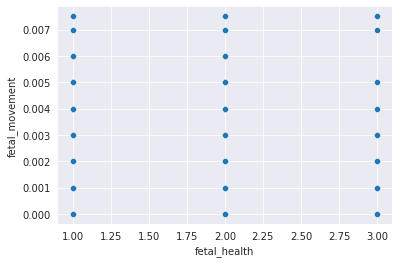

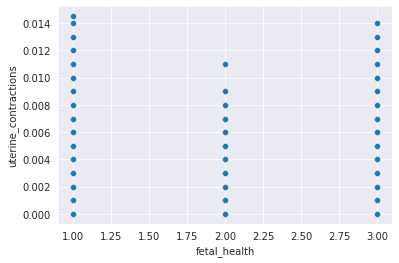

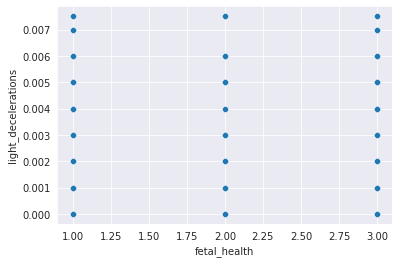

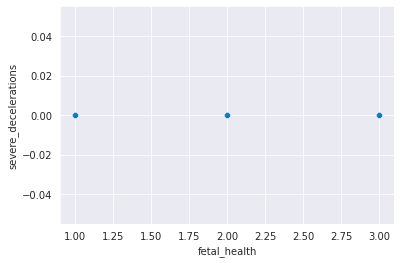

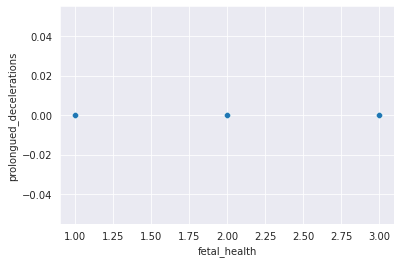

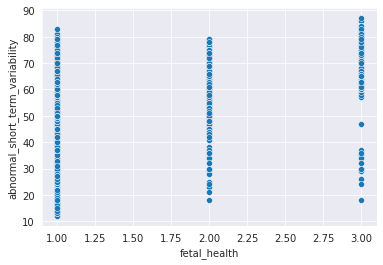

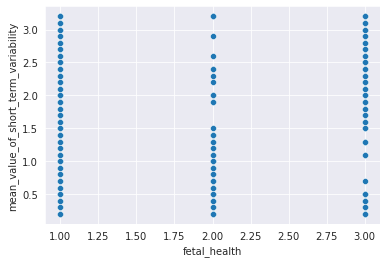

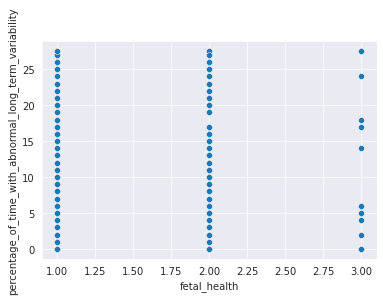

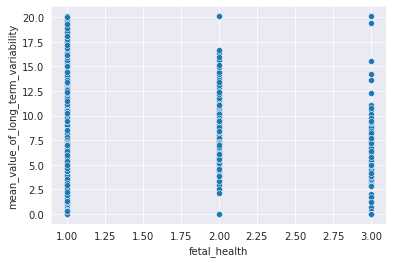

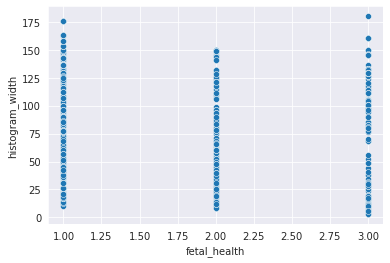

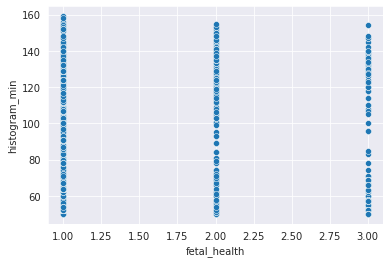

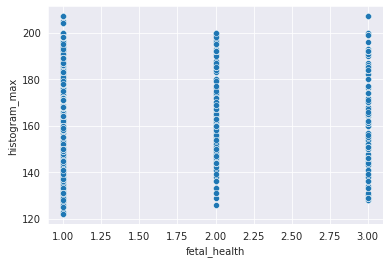

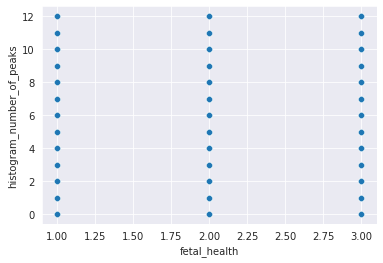

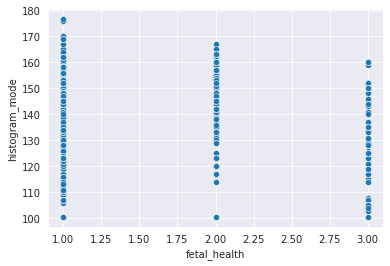

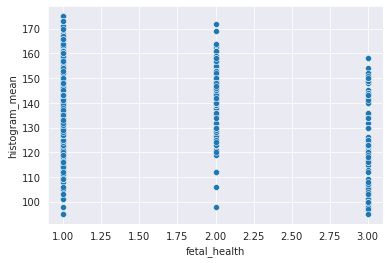

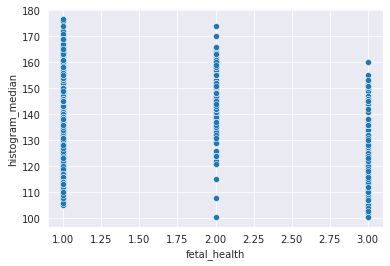

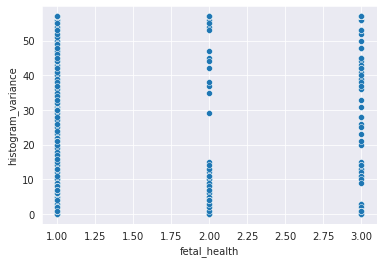

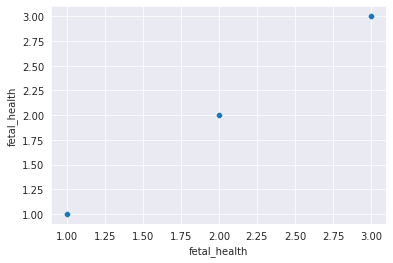

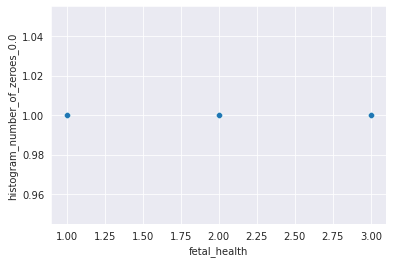

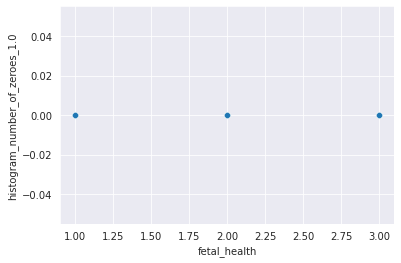

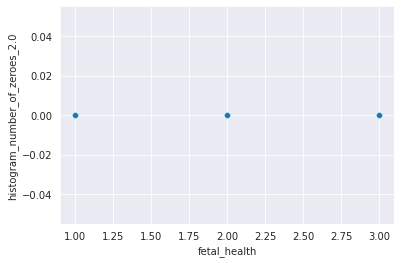

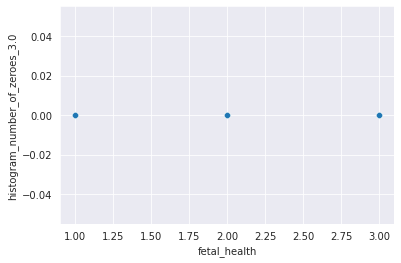

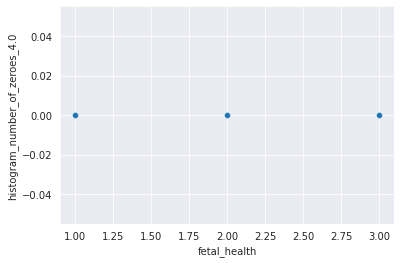

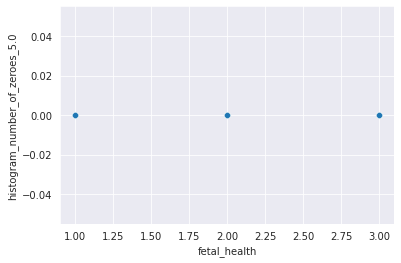

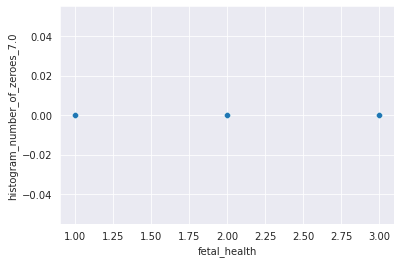

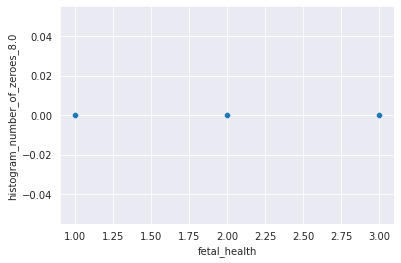

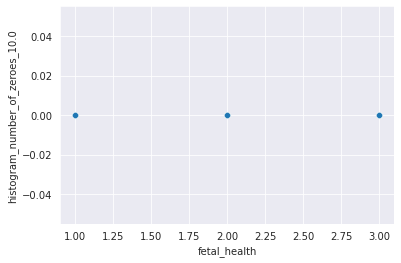

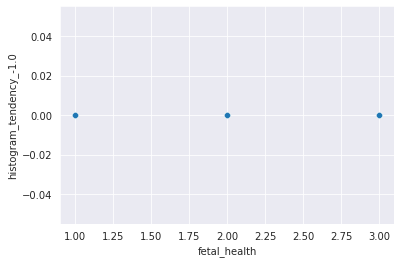

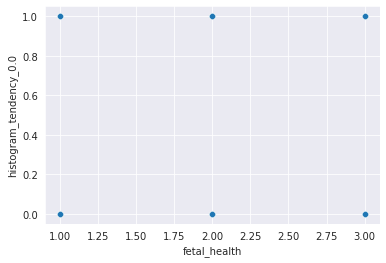

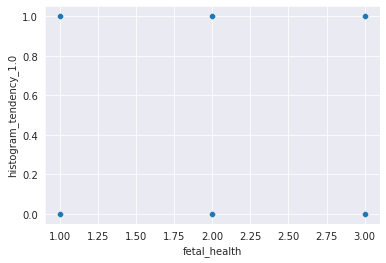

In [16]:
for i in data_outlier.columns:
    plt.figure()
    sns.scatterplot('fetal_health',i,data=data_outlier)

In [17]:
X=data_outlier.drop('fetal_health',axis=1)
y=data_outlier['fetal_health']
feature_selected_columns=[]
bestfeatures = SelectKBest(score_func=chi2, k=30)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
imp_cols=pd.concat([dfscores,dfcolumns],axis=1)
imp_cols.columns = ['Specs','Score']  #naming the dataframe columns
feature_selected_columns=[i for i in imp_cols.sort_values(ascending=False, by='Specs')[:14]['Score']]
feature_selected_columns.append('fetal_health')
unimportant_features=imp_cols[imp_cols['Specs'].isna()==True]['Score']
unimportant_features_final=[]
for i in unimportant_features:
    unimportant_features_final.append(i)

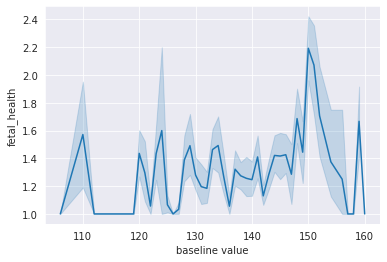

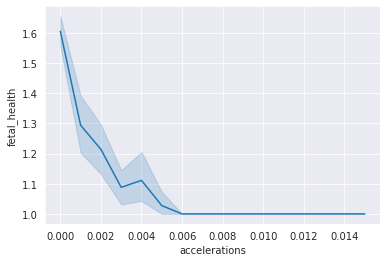

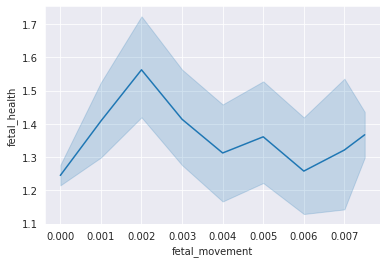

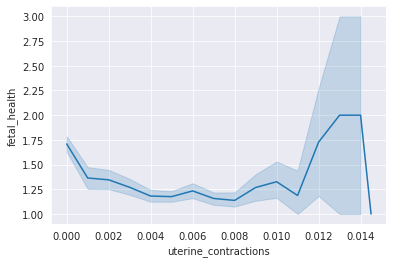

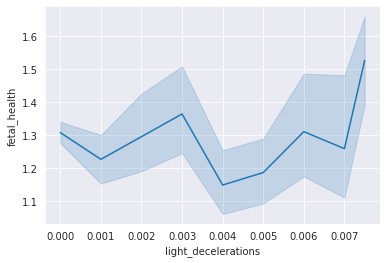

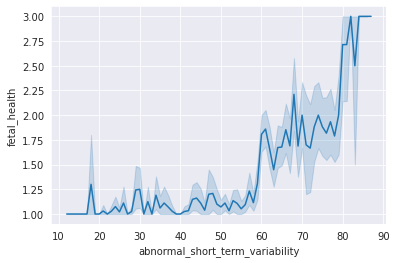

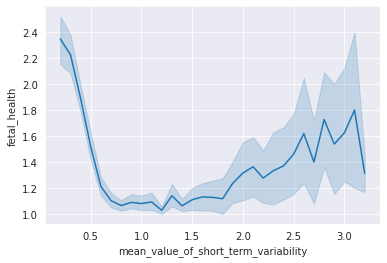

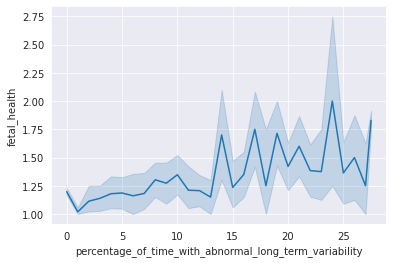

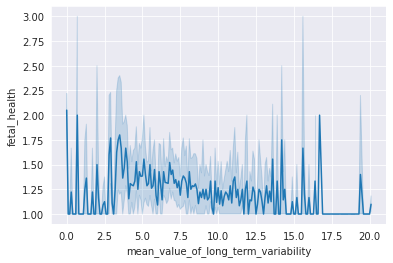

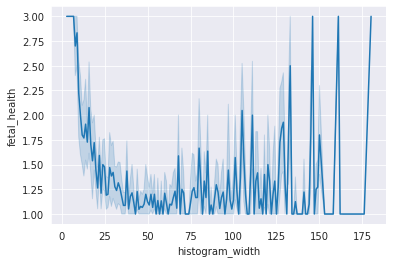

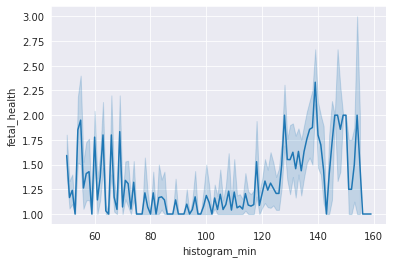

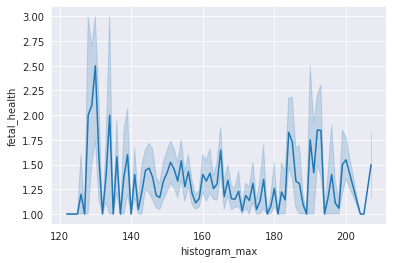

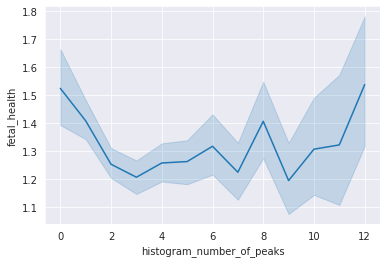

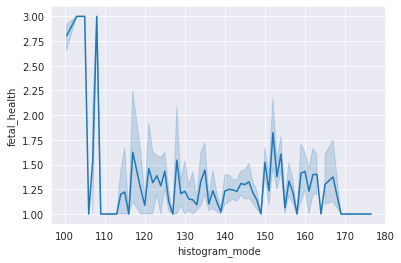

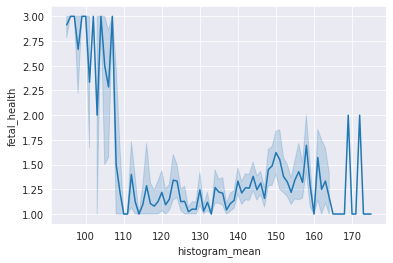

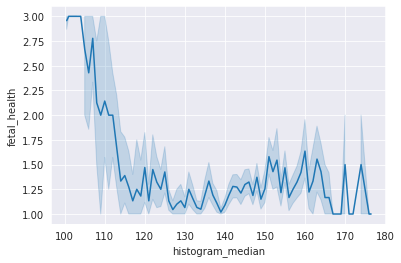

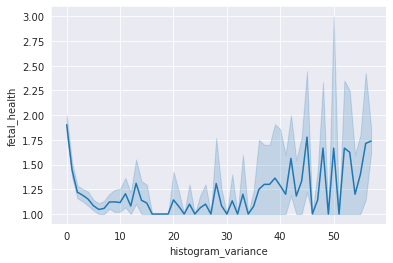

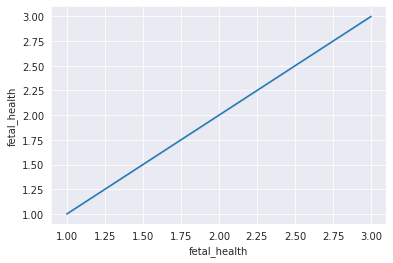

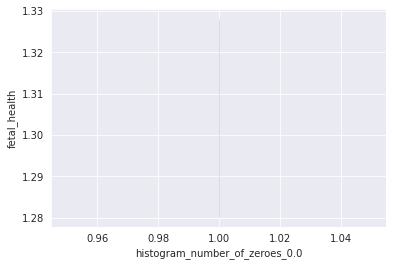

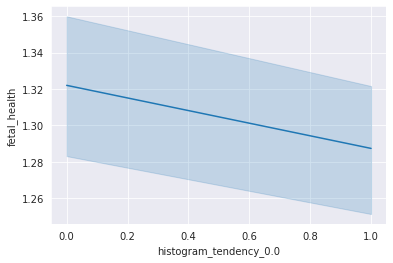

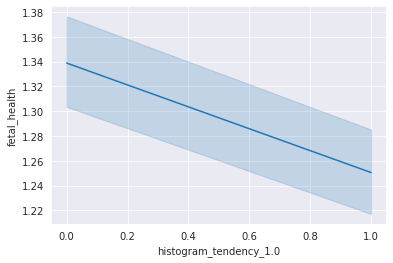

In [18]:
for i in data_outlier.columns:
    if i not in unimportant_features_final:
        plt.figure()
        sns.lineplot(y='fetal_health',x=i,data=data_outlier)

In [19]:
data_outlier_removal2=data_outlier.copy()

for i in unimportant_features_final:
    data_outlier_removal2.drop(i,axis=1,inplace=True)

In [20]:
data3=data_outlier_removal2.copy()

In [21]:
len(data3.columns)

21

In [22]:
data3['fetal_health']=data3['fetal_health'].apply(np.int64)

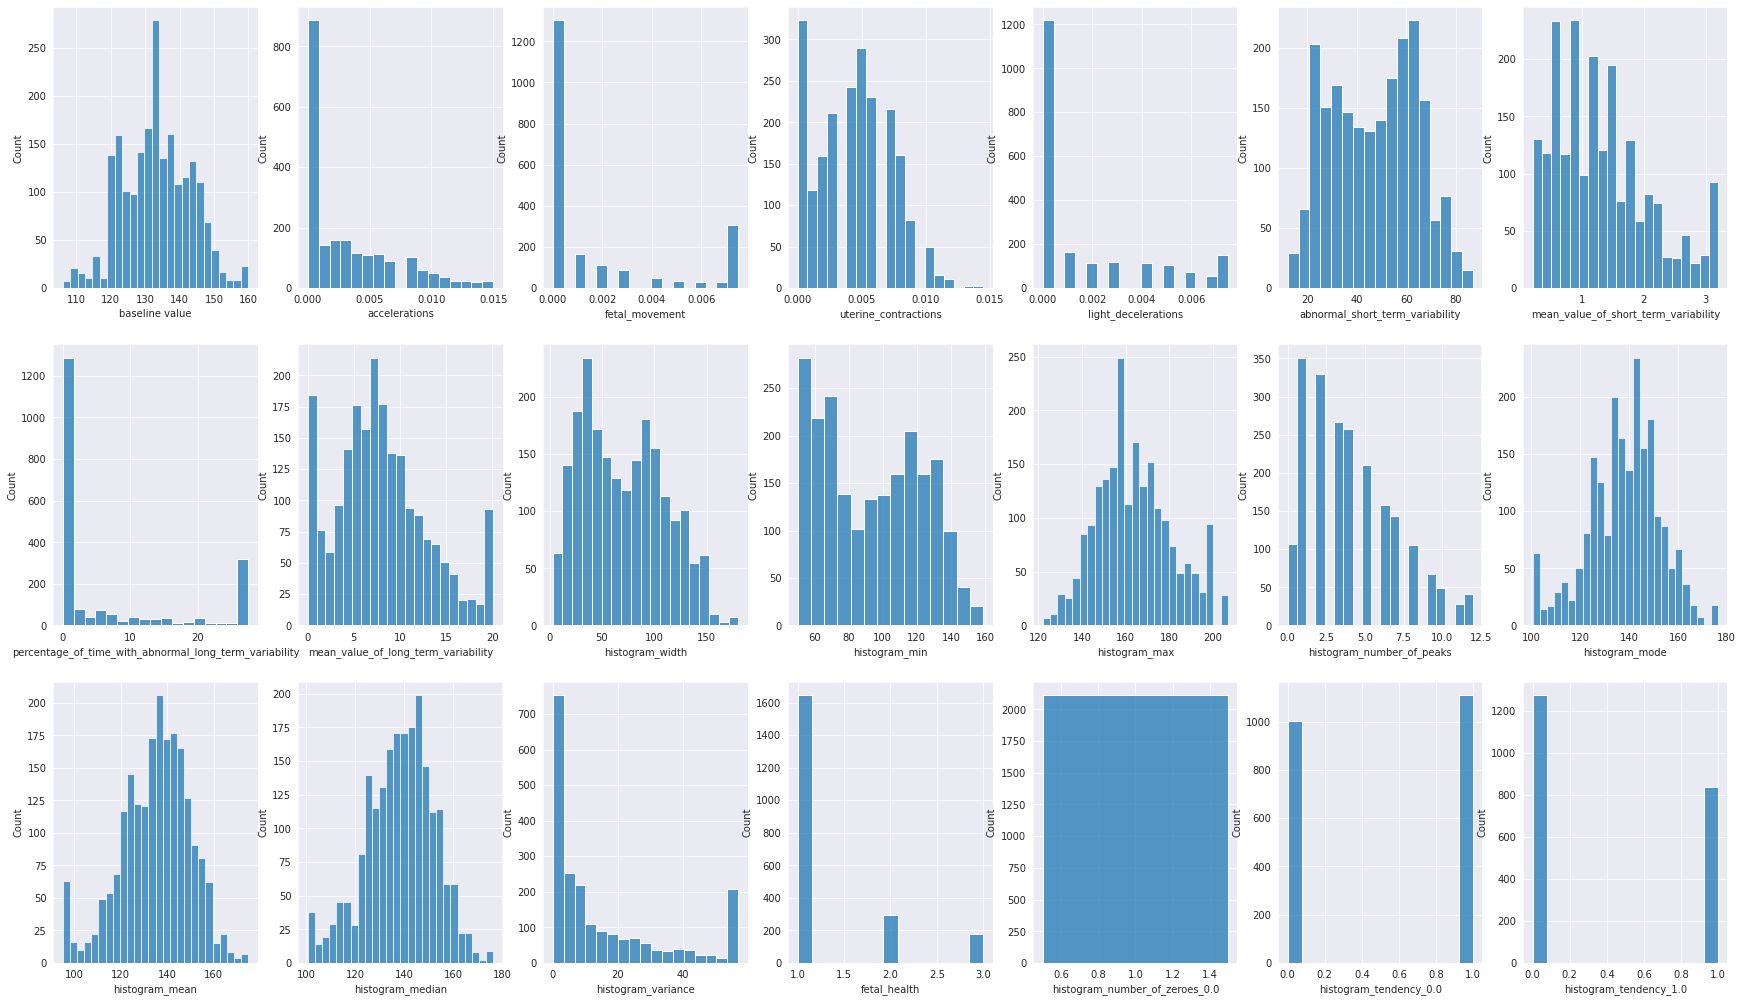

In [23]:
plt.figure(figsize=(30,30))
for i,j in enumerate(data3.columns):
    plt.subplot(5,7,i+1)
    sns.histplot(data3[j])
plt.show()


In [24]:
from sklearn.preprocessing import StandardScaler
sdd=StandardScaler()
data4=data3.copy()
data5=pd.DataFrame(sdd.fit_transform(data3),columns=data4.columns)

In [25]:
X=data5.drop('fetal_health',axis=1)
y=data3['fetal_health']

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [27]:
!pip install imbalanced-learn

In [28]:
import imblearn
print(imblearn.__version__)
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline 

0.9.0


undersample = CondensedNearestNeighbour(n_neighbors=3)
X1, y1 = undersample.fit_resample(X_train, y_train)

In [29]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)

pipeline = Pipeline(steps=[('o', oversample), ('u', undersample)])
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

In [30]:
y_over.value_counts()

1    1163
3    1163
2     195
Name: fetal_health, dtype: int64

In [31]:
dtc=DecisionTreeClassifier()
dtc.fit(X_over, y_over)
dtcp=dtc.predict(X_test)
accuracy_score(dtcp,y_test)

0.8943217665615142

In [32]:
cb=CatBoostClassifier(verbose=0)
cb.fit(X_over, y_over)
m=cb.predict(X_test)
accuracy_score(m,y_test)

0.9227129337539433

In [33]:
lg=LGBMClassifier()
lg.fit(X_over, y_over)
ll=lg.predict(X_test)
accuracy_score(ll,y_test)

0.9321766561514195

In [34]:
final_model = VotingClassifier(estimators=[('cb', cb), ('lg', lg)], voting='soft')
final_model.fit(X_over, y_over)
pred_final = final_model.predict(X_test)
accuracy_score(pred_final,y_test)

0.9274447949526814

In [35]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(final_model, X,y, scoring='accuracy', cv=cv, n_jobs=-1)

In [36]:
scores.mean()

0.9460699275686311